# Noise2Self for Astro

In astronomy datasets, one often acquires many images of the same part of the sky, with different shot, read-out, cosmic ray, and detector noise. Instead of averaging those images, we may train a network to predict one from the other. The resulting output will be a denoised image.

In the simplest case, we have two or more images, and we may use one two predict the other (the Noise2Noise regime). Given more images, we may design a more complicated architecture to take advantage of their multiplicity (instead of merely averaging them to make pairs).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

# Nord Data

In [4]:
import h5py
hf = h5py.File('../data/data_astro_sim_v20190509_samescale.h5', 'r')
data = hf.get('imageset')

Below are two measurements of the same (synthetic) region of the sky.

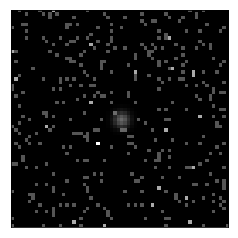

In [26]:
show(data[0,0], vmax = 3)

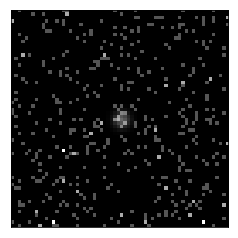

In [27]:
 show(data[0,1], vmax = 3)

# Model

For our model, we use a short UNet with two levels of up- and down- sampling

In [7]:
from models.babyunet import BabyUnet
model = BabyUnet()

In [8]:
from util import getbestgpu
# device = getbestgpu()
device = 0

In [9]:
model = model.to(device)

# Training

In [10]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.0003)

In [11]:
data_loader = DataLoader(data, batch_size=32, shuffle=False)

In [12]:
n_epochs = 1
for epoch in range(n_epochs):
    for i, batch in enumerate(data_loader):
        batch = batch.to(torch.float)
        noisy_images_1, noisy_images_2 = batch[:,0:1], batch[:,1:2]
        noisy_images_1 = noisy_images_1.to(device)
        noisy_images_2 = noisy_images_2.to(device)

        net_output = model(noisy_images_1)

        loss = loss_function(net_output, noisy_images_2)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if i % 10 == 0:
            print("Loss (", i, "): \t", round(loss.item(), 4))

Loss ( 0 ): 	 0.3597
Loss ( 10 ): 	 0.1499
Loss ( 20 ): 	 0.1261
Loss ( 30 ): 	 0.1188
Loss ( 40 ): 	 0.1127
Loss ( 50 ): 	 0.1093
Loss ( 60 ): 	 0.1105
Loss ( 70 ): 	 0.1082
Loss ( 80 ): 	 0.1049
Loss ( 90 ): 	 0.1066
Loss ( 100 ): 	 0.1043
Loss ( 110 ): 	 0.1043
Loss ( 120 ): 	 0.1029
Loss ( 130 ): 	 0.1036
Loss ( 140 ): 	 0.1017
Loss ( 150 ): 	 0.1012
Loss ( 160 ): 	 0.1018
Loss ( 170 ): 	 0.103
Loss ( 180 ): 	 0.1012
Loss ( 190 ): 	 0.1001
Loss ( 200 ): 	 0.1023
Loss ( 210 ): 	 0.1007
Loss ( 220 ): 	 0.1023
Loss ( 230 ): 	 0.1019
Loss ( 240 ): 	 0.1015
Loss ( 250 ): 	 0.1005
Loss ( 260 ): 	 0.1004
Loss ( 270 ): 	 0.1015
Loss ( 280 ): 	 0.0997
Loss ( 290 ): 	 0.1007
Loss ( 300 ): 	 0.0998
Loss ( 310 ): 	 0.1005
Loss ( 0 ): 	 0.1008
Loss ( 10 ): 	 0.0998
Loss ( 20 ): 	 0.0987
Loss ( 30 ): 	 0.101
Loss ( 40 ): 	 0.0997
Loss ( 50 ): 	 0.0994
Loss ( 60 ): 	 0.102
Loss ( 70 ): 	 0.1019
Loss ( 80 ): 	 0.0994
Loss ( 90 ): 	 0.1019
Loss ( 100 ): 	 0.1009
Loss ( 110 ): 	 0.1013
Loss ( 120 ):

In [28]:
test_data_loader = DataLoader(data,
                              batch_size=32,
                              shuffle=False)
i, test_batch = next(enumerate(test_data_loader))
test_batch = test_batch.to(torch.float)
noisy_images_1, noisy_images_2 = test_batch[:,0:1], test_batch[:,1:2]
noisy_images_1 = noisy_images_1.to(device)
noisy_images_2 = noisy_images_2.to(device)

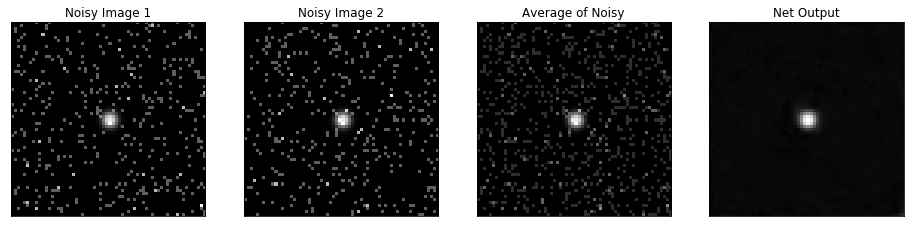

In [30]:
output = model(noisy_images_1.to(device))
idx = 12
plot_tensors([noisy_images_1[idx],
              noisy_images_2[idx],
              0.5*(noisy_images_1[idx] + noisy_images_2[idx]),
              output[idx]],
            ["Noisy Image 1", "Noisy Image 2", "Average of Noisy", "Net Output"])